In [19]:
import pandas as pd
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.spatial
from copy import deepcopy
from random import uniform
from math import sqrt
from collections import Counter
from sklearn.cluster import KMeans


In [3]:
df = pd.read_csv(
    'iris.data',
    header=None, 
    names=['Sepal Length','Sepal Width','Petal Length','Petal Width','Class']
)

In [339]:
df

,Sepal Length,Sepal Width,Petal Length,Petal Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [7]:
def inflate(arr,factor):
    for _ in range(factor):
        noise = np.random.normal(0,0.05,len(arr))
        arr = arr.append(arr+noise)
    return arr

In [25]:
petals = df.iloc[:,2:4]
## Increase the number of entries by |x|^10
x_coords = inflate(petals['Petal Length'],10)
y_coords = inflate(petals['Petal Width'],10)
## Keep a version with both axes
data = pd.concat([x_coords, y_coords], axis=1)

In [9]:
k=2
N = 10

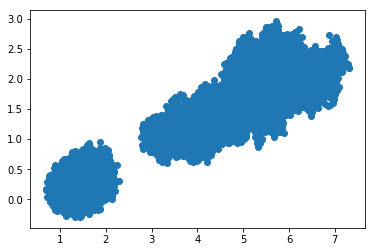

In [342]:
plt.scatter(x_coords,y_coords)
plt.show()

In [332]:
'''
K-means reference implementation
'''
def k_means_naive(x_coords,y_coords,k):
    set_len = float(len(x_coords))
    ## Euclidean Distance Function
    euc_dist = lambda x1,y1,x2,y2:sqrt((x1-x2)**2+(y1-y2)**2)
    
    ## Pick k random centers
    centers = [(0,0)]*k
    new_centers = [(uniform(0,7),uniform(0,2.5)) for _ in range(k)]
    ##Initialize center choices
    center_choice = [0]*len(x_coords)
    
    while new_centers != centers:
        centers = deepcopy(new_centers)
        ## Foreach coordinate
        for i, (x, y) in enumerate(zip(x_coords,y_coords)):
            ## Find the nearest center
            min_d = euc_dist(x,y,*centers[0])
            for j,(center_x,center_y) in enumerate(centers):
                d = euc_dist(x,y,center_x,center_y)
                ## Assign center
                if d<min_d:
                    min_d = d
                    center_choice[i] = j

        ## Find new centers
        for i in range(len(centers)):
            new_x = sum([x for x,c in zip(x_coords,center_choice) if c == i])/set_len
            new_y = sum([y for y,c in zip(y_coords,center_choice)  if c == i])/set_len
            new_centers[i] = new_x,new_y
            
    
    return center_choice,centers

In [346]:
from numba import jit
import numba

# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.

'''
K-means with numba
'''
def k_means_numba(x_coords,y_coords,k):
    seed_centers = [(uniform(0,7),uniform(0,2.5)) for _ in range(k)]
    return k_means_numba_jit(x_coords,y_coords,k,seed_centers)
@jit
## Euclidean Distance Function
def euc_dist(x1,y1,x2,y2):
    return sqrt((x1-x2)**2+(y1-y2)**2)

@numba.jit(parallel=True)
def k_means_numba_jit(x_coords,y_coords,k,seed_centers):
    set_len = float(len(x_coords))

    ## Pick k random centers
    centers = [(0,0)]*k
    new_centers = seed_centers
    ##Initialize center choices
    center_choice = [0]*len(x_coords)
    
    while new_centers != centers:
        centers = deepcopy(new_centers)
        ## Foreach coordinate
        for i, (x, y) in enumerate(zip(x_coords,y_coords)):
            ## Find the nearest center
            min_d = euc_dist(x,y,*centers[0])
            for j,(center_x,center_y) in enumerate(centers):
                d = euc_dist(x,y,center_x,center_y)
                ## Assign center
                if d<min_d:
                    min_d = d
                    center_choice[i] = j

        ## Find new centers
        for i in range(len(centers)):
            sum_x=sum_y=0.0
            for x,y,c in zip(x_coords,y_coords,center_choice):
                if c == i:
                    sum_x+=x
                    sum_y+=y
            
            new_centers[i] = sum_x/set_len,sum_y/set_len
            
    
    return center_choice,centers

In [32]:
def kmeans_numpy(data, k, max_iterations=20):
    ## Convert input to numpy array
    data = np.array(data)
    ## Pick k random centers
    centers = data[np.random.choice(np.arange(len(data)), k, False)]

    ## Have a maximum number of iterations to avoid infinite loop
    for _ in range(max_iterations):
        ## Find the nearest center
        sqdists = scipy.spatial.distance.cdist(centers, data, 'sqeuclidean')
        center_choice = np.argmin(sqdists, axis=0)

        ## Compute new centers
        new_centers = np.empty(shape=(k,) + data.shape[1:])
        for i in range(k):
            np.mean(data[center_choice == i], axis=0, out=new_centers[i])
        
        if np.array_equal(new_centers, centers):
            break

        centers = new_centers

    return center_choice, centers

In [271]:
center_choices,centers = k_means_naive(x_coords,y_coords,k)

Wall time: 15.7 s


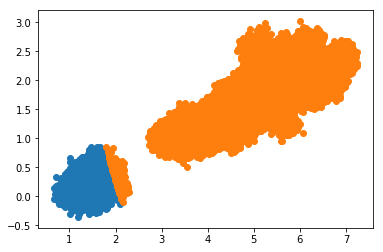

In [328]:
for i in range(k):
    xi = [x for x,c in zip(x_coords,center_choices) if c == i]
    yi = [y for y,c in zip(y_coords,center_choices)  if c == i]
    plt.scatter(xi,yi)
plt.show()

In [333]:
## Base version
%time for _ in range(N): center_choices,centers = k_means_naive(x_coords,y_coords,k)

Wall time: 17.6 s


In [348]:
## Numba
%time for _ in range(N): center_choices,centers = k_means_numba(x_coords,y_coords,k)

Wall time: 11.9 s


In [33]:
## Numpy
%time for _ in range(N): center_choices = kmeans_numpy(data,k)

Wall time: 1.11 s


In [18]:
'''
Existing implementation
'''
def k_means_scikit():
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(petals)
    labels = kmeans.predict(petals)
    centroids = kmeans.cluster_centers_
%time for _ in range(N): k_means_scikit()

Wall time: 141 ms
